In [1]:
# In this program first I will preprocess the dataset. By preprocessing I mean replace the gene symbol values
# with there mean or median 
# first I will choose the right value for replacing based on standard deviation and then I will choose the right value 
# based on coefficient of variation
# After that I have two preprocessed datasets then apply Lasso separately on both of them
# I will creat a venn diagram with the selected features by lasso from two preprocessed datasets

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import csv
import pickle
import statistics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.linear_model import Lasso
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from matplotlib_venn import venn2, venn2_circles

In [4]:
# we need the final dataset to begin with

In [3]:
# build the final data frame

# loading the dataset which has the features (gene symbol)
file_path = 'dataset/ADNI_Gene_Expression_Profile.csv'
df1 = pd.read_csv(file_path)

# df1.head()

col = df1.columns[3:747]
# print(len(c))
sampleList = []
for c in col:
    sample = df1.loc[:, c]
    sample = sample.tolist()
    sampleList.append(sample)
    
file_path = 'dataset/Complete_ADNI_clinical_info.csv'
df2 = pd.read_csv(file_path)

# df2.head(10)

tem_col = list(df1['Unnamed: 2'])
tem_col[1] = 'IID'

finalDataFrame = pd.DataFrame(sampleList, columns=tem_col)
finalDataFrame = finalDataFrame.loc[:, finalDataFrame.columns.notna()]
finalDataFrame = finalDataFrame.drop(columns=['Symbol'])

finalDataFrame['Phenotype'] = ""

for index, row in finalDataFrame.iterrows():
    patientID = finalDataFrame.at[index, 'IID']
    # cell_value = df.at[row_number, column_name]
    #print("P ID: ", patient)
    for index2, row2 in df2.iterrows():
        if df2.at[index2, 'IID'] == patientID:
            finalDataFrame.at[index, 'Phenotype'] = df2.at[index2, 'Phenotype']

In [7]:
# finalDataFrame.head()

In [4]:
pickle_file_name = 'keyDictionaryPickel.pickle'
with open(pickle_file_name, 'rb') as file:
    keyDictionary = pickle.load(file)

In [8]:
# load the csv file where metrics of gene symbol are stored

In [5]:
geneMetrics = pd.read_csv("dataset/Gene_Metrics_Info.csv")

In [13]:
# now we will look at the density plot of mean standard deviation of 12500 gene symbols that 
# have more than one expression values for multiple probe set

<Axes: xlabel='Mean Standard Deviation', ylabel='Density'>

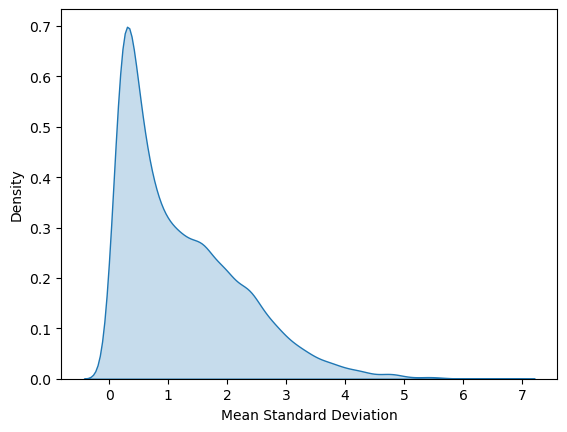

In [14]:
sns.kdeplot(geneMetrics["Mean Standard Deviation"], shade=True)

In [15]:
# from observing this density plot we found out 1.5 is the good threshold to decide low or high standard deviation

In [16]:
# I will build a dictionary lowHighGeneSymbolBasedOnStd. In this dictionary, key are gene symbols
# values of this dictionary can be 0 or 1. 0 means low mean standard deviation ( <= 1.5) and 1 means high 
# mean standard deviation (> 1.5)

In [7]:
lowHighGeneSymbolBasedOnStd = {}

for index, row in geneMetrics.iterrows():
    msd = geneMetrics.at[index, 'Mean Standard Deviation']
    key = geneMetrics.at[index, 'Gene Symbol']
    if msd > 1.5:
        lowHighGeneSymbolBasedOnStd[key] = 1
    else:
        lowHighGeneSymbolBasedOnStd[key] = 0

In [8]:
columns =  set(finalDataFrame.columns)
idxs = finalDataFrame["IID"]

In [9]:
dic = defaultdict(list)
for idx in idxs:
    for col in columns:
        res = keyDictionary.get((idx, col))
        if res:
            if lowHighGeneSymbolBasedOnStd[col] == 0:
                dic[col].append(np.mean(res))
            else:
                dic[col].append(np.median(res))
lastBasedOnStd = pd.DataFrame(dic)

In [26]:
# lastBasedOnStd.head()

In [10]:
original_col = finalDataFrame.columns
new_colBasedOnStd = lastBasedOnStd.columns
disjointBasedOnStd = [i for i in original_col if i not in new_colBasedOnStd]
lastBasedOnStd = lastBasedOnStd.merge(finalDataFrame[disjointBasedOnStd], left_index=True, right_index=True)

In [11]:
lastBasedOnStd.replace("", np.nan, inplace=True)

In [12]:
sum(lastBasedOnStd.isna().sum())

16

In [13]:
lastBasedOnStd = lastBasedOnStd[lastBasedOnStd["Phenotype"].notna()].reset_index(drop=True)

In [14]:
sum(lastBasedOnStd.isna().sum())

0

In [15]:
for col in lastBasedOnStd.columns:
    if (
        any(lastBasedOnStd[col].isna())
        and lastBasedOnStd[col].isna().value_counts().to_dict().get(True) / len(lastBasedOnStd[col])
        > 0.90
    ):
        print(col)
        lastBasedOnStd = lastBasedOnStd.drop(col, axis=1)

In [36]:
# now lastBasedOnStd is ready 

In [16]:
featuresBasedOnStd = lastBasedOnStd.drop('Phenotype', axis = 1)
targetBasedOnStd = lastBasedOnStd['Phenotype']

In [17]:
featuresBasedOnStd = featuresBasedOnStd.drop('IID', axis = 1)

In [18]:
lasso1 = Lasso(alpha=0.01)
lasso1.fit(featuresBasedOnStd, targetBasedOnStd)
selectedFeaturesBasedOnStd = featuresBasedOnStd.columns[lasso1.coef_ != 0.0]

In [19]:
len(selectedFeaturesBasedOnStd)

318

In [46]:
# now we will look at the density plot of coefficient of variation of 12500 gene symbols that 
# have more than one expression values for multiple probe set

<Axes: xlabel='Mean CV', ylabel='Density'>

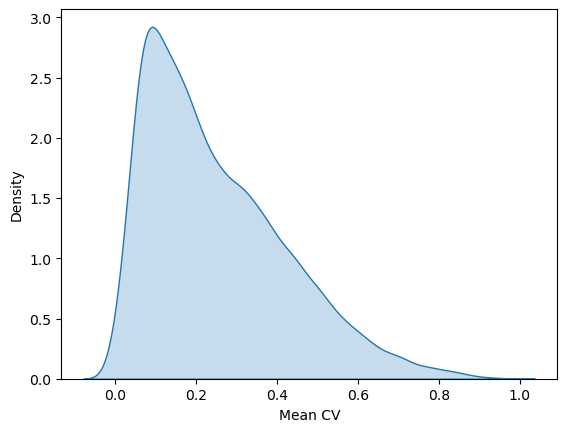

In [47]:
sns.kdeplot(geneMetrics["Mean CV"], shade=True)

In [48]:
# from observing this density plot we found out 0.35 is the good threshold to decide low or high standard deviation

In [ ]:
# I will build a dictionary lowHighGeneSymbolBasedOnCV. In this dictionary, key are gene symbols
# values of this dictionary can be 0 or 1. 0 means low mean CV ( <= 0.35) and 1 means high 
# mean CV (> 0.35)

In [20]:
lowHighGeneSymbolBasedOnCV = {}

for index, row in geneMetrics.iterrows():
    mcv = geneMetrics.at[index, 'Mean CV']
    key = geneMetrics.at[index, 'Gene Symbol']
    if mcv > 0.35:
        lowHighGeneSymbolBasedOnCV[key] = 1
    else:
        lowHighGeneSymbolBasedOnCV[key] = 1

In [21]:
columns =  set(finalDataFrame.columns)
idxs = finalDataFrame["IID"]

In [22]:
dic = defaultdict(list)
for idx in idxs:
    for col in columns:
        res = keyDictionary.get((idx, col))
        if res:
            if lowHighGeneSymbolBasedOnCV[col] == 0:
                dic[col].append(np.mean(res))
            else:
                dic[col].append(np.median(res))
lastBasedOnCV = pd.DataFrame(dic)

In [53]:
# lastBasedOnCV

In [23]:
original_col = finalDataFrame.columns
new_colBasedOnCV = lastBasedOnCV.columns
disjointBasedOnCV = [i for i in original_col if i not in new_colBasedOnCV]
lastBasedOnCV = lastBasedOnCV.merge(finalDataFrame[disjointBasedOnCV], left_index=True, right_index=True)

In [24]:
lastBasedOnCV.replace("", np.nan, inplace=True)
print(sum(lastBasedOnCV.isna().sum()))
lastBasedOnCV = lastBasedOnCV[lastBasedOnCV["Phenotype"].notna()].reset_index(drop=True)
print(sum(lastBasedOnCV.isna().sum()))

16
0


In [25]:
for col in lastBasedOnCV.columns:
    if (
        any(lastBasedOnCV[col].isna())
        and lastBasedOnCV[col].isna().value_counts().to_dict().get(True) / len(lastBasedOnCV[col])
        > 0.90
    ):
        print(col)
        lastBasedOnCV = lastBasedOnCV.drop(col, axis=1)

In [26]:
featuresBasedOnCV = lastBasedOnCV.drop('Phenotype', axis = 1)
targetBasedOnCV = lastBasedOnCV['Phenotype']

In [27]:
featuresBasedOnCV = featuresBasedOnCV.drop('IID', axis = 1)

In [28]:
lasso2 = Lasso(alpha=0.01)
lasso2.fit(featuresBasedOnCV, targetBasedOnCV)
selectedFeaturesBasedOnCV = featuresBasedOnCV.columns[lasso2.coef_ != 0.0]

In [29]:
len(selectedFeaturesBasedOnCV)

327

In [30]:
selectedFeaturesInBoth = []
for feature in selectedFeaturesBasedOnStd:
    if feature in selectedFeaturesBasedOnCV:
        selectedFeaturesInBoth.append(feature)

In [31]:
len(selectedFeaturesInBoth)

263

In [34]:
csv_file = "selectedFeaturesInBoth.csv"

# Open the CSV file in write mode
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write the strings to the CSV file, one per row in the first column
    for string in selectedFeaturesInBoth:
        writer.writerow([string])

In [63]:
selectedFeaturesBasedOnStdList = selectedFeaturesBasedOnStd.tolist()
selectedFeaturesBasedOnCVList = selectedFeaturesBasedOnCV.tolist()

In [64]:
print(len(selectedFeaturesBasedOnStdList))
print(len(selectedFeaturesBasedOnCVList))

318
328


In [62]:
# now I will represent this two set of selected features by Venn Diagram

In [65]:
inBothList = 0

for feature in selectedFeaturesBasedOnStdList:
    if feature in selectedFeaturesBasedOnCVList:
        inBothList += 1
        
onlyInFirstList = len(selectedFeaturesBasedOnStdList) - inBothList
onlyInSecondList = len(selectedFeaturesBasedOnCVList) - inBothList

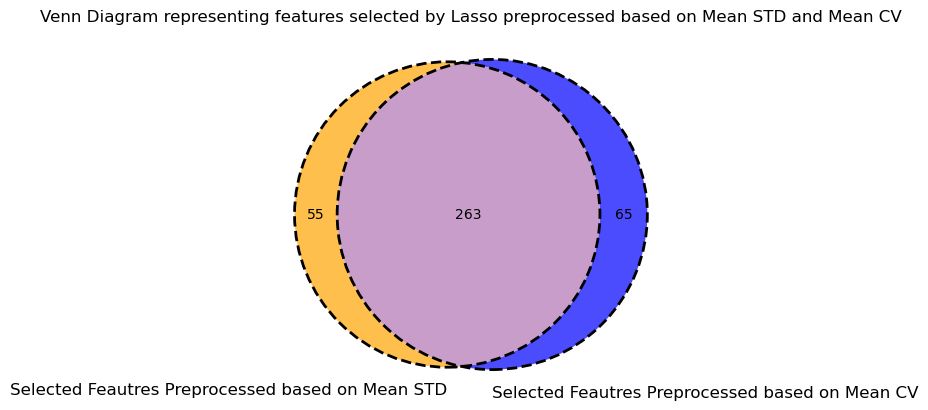

In [68]:
# depict venn diagram 
venn2(subsets=(onlyInFirstList, onlyInSecondList, inBothList),  
      set_labels=('Selected Feautres Preprocessed based on Mean STD', 'Selected Feautres Preprocessed based on Mean CV'), 
      set_colors=("orange", "blue"), alpha=.7) 
  
# add outline 
venn2_circles(subsets=(onlyInFirstList, onlyInSecondList, inBothList),  
              linestyle="dashed",  
              linewidth=2) 
  

# assign title of the venn diagram 
plt.title("Venn Diagram representing features selected by Lasso preprocessed based on Mean STD and Mean CV")   
plt.show()